In [5]:
# import of libs
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [6]:
# connection to clickhouse
connection = {  'host': 'http://clickhouse.beslan.pro:8080',        
                'database':'default',
                'user':'student', 
                'password':'dpo_python_2020'
             } 

In [7]:
# query text, number of rows in ldn_listings
query = '''
SELECT count(*) rows_count
FROM ldn_listings
'''

In [4]:
# query to base and result
query_base = ph.read_clickhouse(query=query, connection=connection)
query_base

,rows_count
0,85207


In [5]:
# number of rows as integer
query_base.rows_count[0]

85207

In [6]:
price_room_type = '''
SELECT
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price_num

FROM ldn_listings
ORDER BY id ASC
LIMIT 1000
'''

In [7]:
q_price_room_type = ph.read_clickhouse(query=price_room_type, connection=connection)
q_price_room_type

,id,room_type,price_num
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0
...,...,...,...
995,541081,Entire home/apt,110.0
996,541363,Entire home/apt,110.0
997,542231,Private room,65.0
998,542646,Entire home/apt,100.0


In [8]:
q_price_room_type.groupby('room_type', as_index=False) \
    .price_num.quantile(q=0.75)

,room_type,price_num
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [9]:
avg_price_raiting = '''
SELECT
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price_num,
    toFloat32OrNull(review_scores_rating) AS review_scores

FROM ldn_listings
WHERE review_scores_rating != ''
ORDER BY id ASC
LIMIT 1000
'''

In [10]:
q_avg_price_raiting = ph.read_clickhouse(query=avg_price_raiting, connection=connection)
q_avg_price_raiting

,id,room_type,price_num,review_scores
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0
...,...,...,...,...
995,616278,Entire home/apt,165.0,100.0
996,617678,Private room,99.0,93.0
997,618082,Private room,45.0,100.0
998,619010,Private room,20.0,88.0


In [11]:
avg_price = q_avg_price_raiting.groupby('room_type', as_index=False) \
    .agg({'price_num': 'mean', 'review_scores': 'mean'})
avg_price

,room_type,price_num,review_scores
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


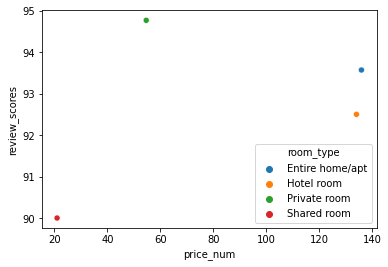

In [12]:
sns.scatterplot(data=avg_price, x="price_num", y="review_scores", hue="room_type")

In [35]:
emotions_query = '''
SELECT
    host_id,
    any(host_verifications) AS host_verifications

FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY host_id
'''

In [36]:
q_emotions_query = ph.read_clickhouse(query=emotions_query, connection=connection)
q_emotions_query

,host_id,host_verifications
0,320901,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1,21276165,"['email', 'phone', 'reviews', 'manual_offline'..."
2,3722204,"['email', 'phone', 'reviews', 'jumio', 'govern..."
3,10961046,"['email', 'phone', 'reviews', 'jumio', 'govern..."
4,18974734,"['email', 'phone', 'reviews', 'jumio', 'govern..."
...,...,...
1356,2110774,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,19680548,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1358,5396573,"['email', 'phone', 'facebook', 'reviews', 'jum..."
1359,25357561,"['email', 'phone', 'reviews', 'jumio', 'govern..."


In [37]:
q_emotions_query.host_verifications = q_emotions_query.host_verifications.str.strip("[]").str.replace("'",'').str.split(', ')

In [38]:
q_emotions_query

,host_id,host_verifications
0,320901,"[email, phone, reviews, jumio, offline_governm..."
1,21276165,"[email, phone, reviews, manual_offline, jumio,..."
2,3722204,"[email, phone, reviews, jumio, government_id]"
3,10961046,"[email, phone, reviews, jumio, government_id]"
4,18974734,"[email, phone, reviews, jumio, government_id]"
...,...,...
1356,2110774,"[email, phone, reviews, jumio, government_id]"
1357,19680548,"[email, phone, reviews, jumio, government_id]"
1358,5396573,"[email, phone, facebook, reviews, jumio, offli..."
1359,25357561,"[email, phone, reviews, jumio, government_id]"


In [39]:
final_emotions_query = q_emotions_query.explode('host_verifications')

In [40]:
final_emotions_query

,host_id,host_verifications
0,320901,email
0,320901,phone
0,320901,reviews
0,320901,jumio
0,320901,offline_government_id
...,...,...
1359,25357561,jumio
1359,25357561,government_id
1360,1956888,email
1360,1956888,phone


In [41]:
final_emotions_query.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [42]:
roma_experience_query = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) AS experiences_count

FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC

LIMIT 100
'''

In [43]:
q_roma_experience_query = ph.read_clickhouse(query=roma_experience_query, connection=connection)

In [46]:
final_roma = q_roma_experience_query.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

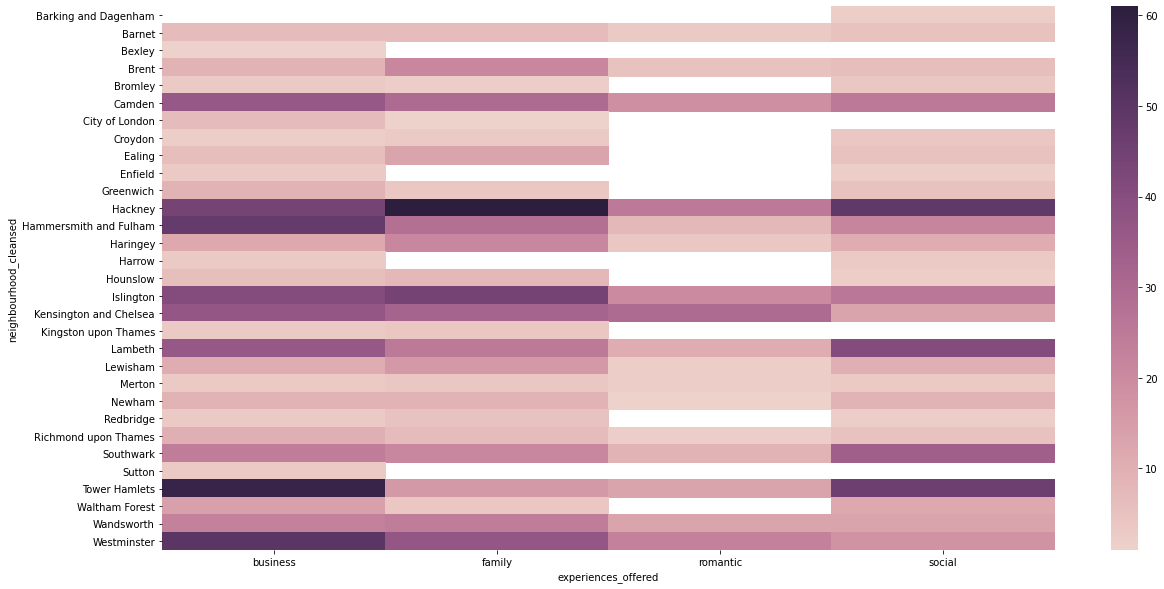

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(final_roma, cmap=sns.cubehelix_palette(as_cmap=True))

In [8]:
# Запрос для: Выгрузите данные о ценах за ночь для разных типов жилья, 
# для которых также доступен какой-либо вид впечатления. 

room_price_roma_query = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) AS price,
    experiences_offered

FROM ldn_listings
WHERE experiences_offered != 'none'
'''

In [9]:
q_room_price_roma_query = ph.read_clickhouse(query=room_price_roma_query, connection=connection)

In [10]:
q_room_price_roma_query['price_log'] = np.log(q_room_price_roma_query.price)

In [11]:
q_room_price_roma_query

,room_type,price,experiences_offered,price_log
0,Private room,65.0,business,4.174387
1,Entire home/apt,100.0,romantic,4.605170
2,Private room,150.0,business,5.010635
3,Private room,45.0,business,3.806663
4,Private room,25.0,business,3.218876
...,...,...,...,...
1543,Entire home/apt,100.0,family,4.605170
1544,Entire home/apt,125.0,business,4.828314
1545,Entire home/apt,185.0,business,5.220356
1546,Entire home/apt,110.0,business,4.700480


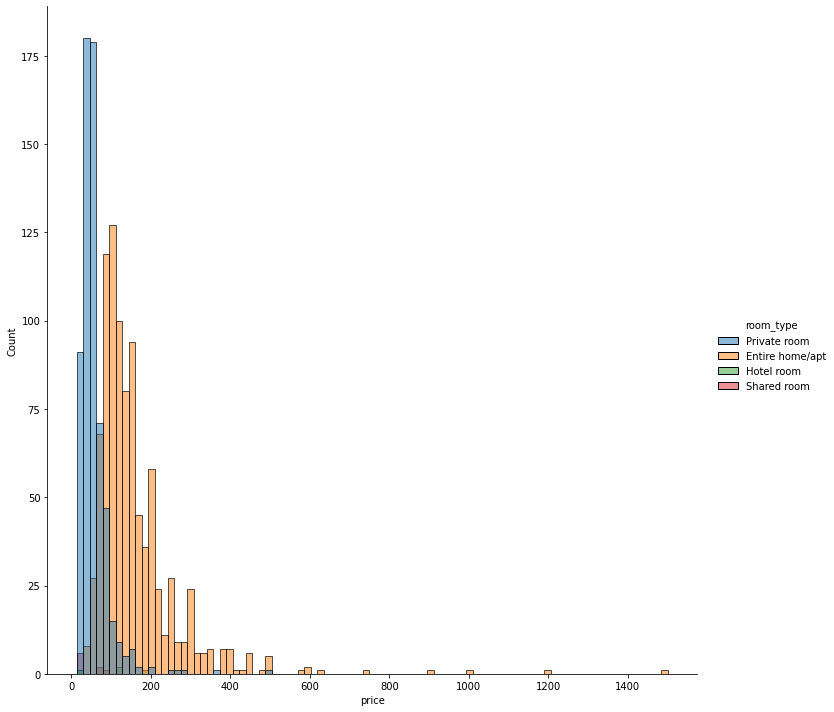

In [108]:
sns.displot(data = q_room_price_roma_query, x = 'price', hue = 'room_type', height=10)

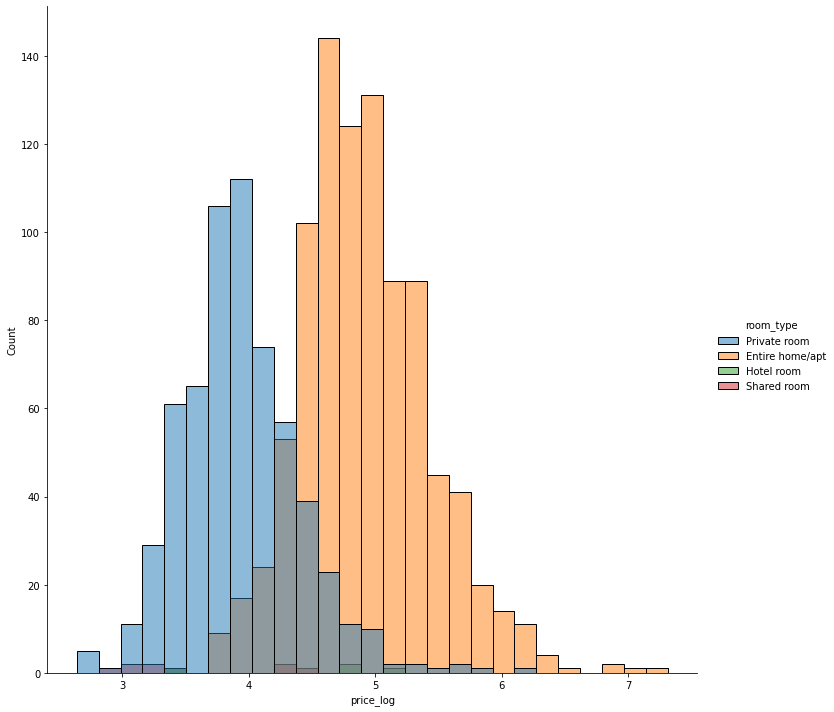

In [107]:
sns.displot(data = q_room_price_roma_query, x = 'price_log', hue = 'room_type', height=10)

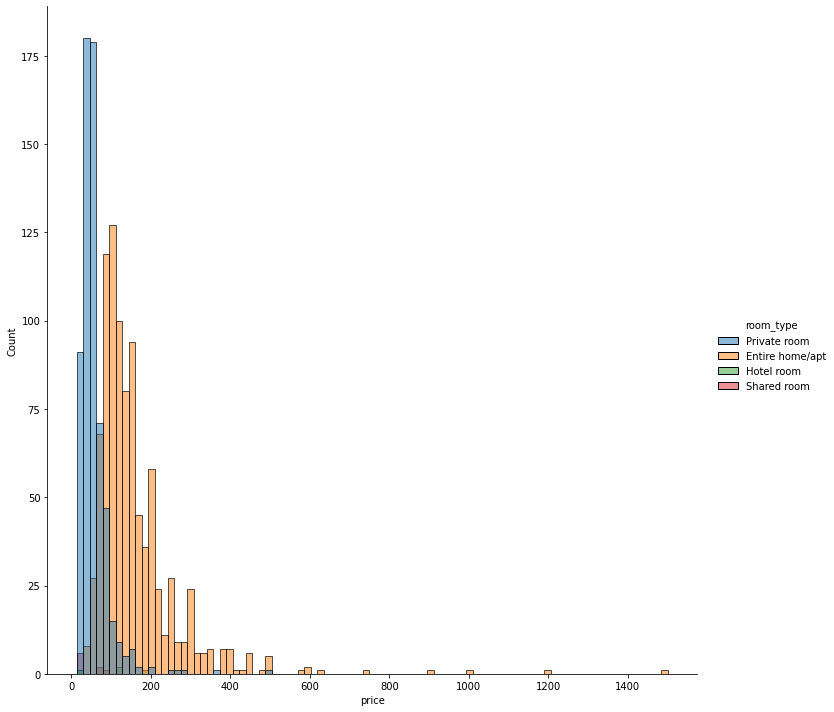

In [113]:
sns.displot(
    q_room_price_roma_query, x="price", hue = 'room_type', height=10)

In [120]:
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.
query_price_date = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) AS price,
    first_review

FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
'''

In [121]:
df_query_price_date = ph.read_clickhouse(query=query_price_date, connection=connection)

In [128]:
df_query_price_date.dtypes

room_type               object
price                  float32
first_review    datetime64[ns]
dtype: object

In [126]:
df_query_price_date.first_review = pd.to_datetime(df_query_price_date.first_review)

In [130]:
df_query_price_date['year'] = df_query_price_date.first_review.dt.year

In [139]:
final_df_price_date = df_query_price_date.groupby(['room_type', 'year'], as_index=False) \
    .agg({'price' : 'mean'}) \
    .sort_values('year', ascending=True)
final_df_price_date.head()

,room_type,year,price
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143


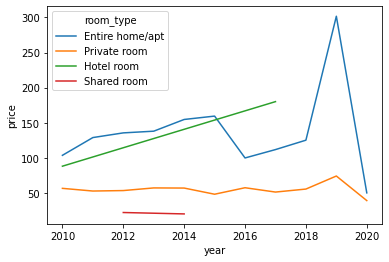

In [141]:
sns.lineplot(data=final_df_price_date, x="year", y="price", hue='room_type')

In [26]:
for index, rows in q_room_price_roma_query.iterrows():
    print(f'index is {index}, row is:\n{rows}\n')
    

index is 0, row is:
room_type              Private room
price                            65
experiences_offered        business
price_log                   4.17439
Name: 0, dtype: object

index is 1, row is:
room_type              Entire home/apt
price                              100
experiences_offered           romantic
price_log                      4.60517
Name: 1, dtype: object

index is 2, row is:
room_type              Private room
price                           150
experiences_offered        business
price_log                   5.01064
Name: 2, dtype: object

index is 3, row is:
room_type              Private room
price                            45
experiences_offered        business
price_log                   3.80666
Name: 3, dtype: object

index is 4, row is:
room_type              Private room
price                            25
experiences_offered        business
price_log                   3.21888
Name: 4, dtype: object

index is 5, row is:
room_type              Priva

index is 277, row is:
room_type              Private room
price                            39
experiences_offered        business
price_log                   3.66356
Name: 277, dtype: object

index is 278, row is:
room_type              Entire home/apt
price                              375
experiences_offered             family
price_log                      5.92693
Name: 278, dtype: object

index is 279, row is:
room_type              Private room
price                            25
experiences_offered        business
price_log                   3.21888
Name: 279, dtype: object

index is 280, row is:
room_type              Entire home/apt
price                              296
experiences_offered             family
price_log                      5.69036
Name: 280, dtype: object

index is 281, row is:
room_type              Private room
price                            69
experiences_offered        business
price_log                   4.23411
Name: 281, dtype: object

index is 282, ro


index is 559, row is:
room_type              Entire home/apt
price                              110
experiences_offered             family
price_log                      4.70048
Name: 559, dtype: object

index is 560, row is:
room_type              Entire home/apt
price                              300
experiences_offered             family
price_log                      5.70378
Name: 560, dtype: object

index is 561, row is:
room_type              Entire home/apt
price                              295
experiences_offered             family
price_log                      5.68698
Name: 561, dtype: object

index is 562, row is:
room_type              Private room
price                            54
experiences_offered        business
price_log                   3.98898
Name: 562, dtype: object

index is 563, row is:
room_type              Private room
price                            59
experiences_offered        business
price_log                   4.07754
Name: 563, dtype: object

ind

index is 842, row is:
room_type              Entire home/apt
price                              106
experiences_offered             family
price_log                      4.66344
Name: 842, dtype: object

index is 843, row is:
room_type              Entire home/apt
price                              169
experiences_offered             family
price_log                       5.1299
Name: 843, dtype: object

index is 844, row is:
room_type              Entire home/apt
price                              128
experiences_offered           romantic
price_log                      4.85203
Name: 844, dtype: object

index is 845, row is:
room_type              Entire home/apt
price                              120
experiences_offered             family
price_log                      4.78749
Name: 845, dtype: object

index is 846, row is:
room_type              Entire home/apt
price                              129
experiences_offered           romantic
price_log                      4.85981
Name: 


index is 1141, row is:
room_type              Entire home/apt
price                               99
experiences_offered           romantic
price_log                      4.59512
Name: 1141, dtype: object

index is 1142, row is:
room_type              Entire home/apt
price                               75
experiences_offered           romantic
price_log                      4.31749
Name: 1142, dtype: object

index is 1143, row is:
room_type              Entire home/apt
price                              140
experiences_offered             family
price_log                      4.94164
Name: 1143, dtype: object

index is 1144, row is:
room_type              Entire home/apt
price                              299
experiences_offered             family
price_log                      5.70044
Name: 1144, dtype: object

index is 1145, row is:
room_type              Entire home/apt
price                               96
experiences_offered             family
price_log                      4.56

index is 1443, row is:
room_type              Private room
price                            99
experiences_offered          social
price_log                   4.59512
Name: 1443, dtype: object

index is 1444, row is:
room_type              Entire home/apt
price                              130
experiences_offered           romantic
price_log                      4.86753
Name: 1444, dtype: object

index is 1445, row is:
room_type              Entire home/apt
price                               95
experiences_offered           business
price_log                      4.55388
Name: 1445, dtype: object

index is 1446, row is:
room_type              Private room
price                            45
experiences_offered          social
price_log                   3.80666
Name: 1446, dtype: object

index is 1447, row is:
room_type              Entire home/apt
price                               89
experiences_offered           business
price_log                      4.48864
Name: 1447, dtype: ob

In [14]:
q_room_price_roma_query

,room_type,price,experiences_offered,price_log
0,Private room,65.0,business,4.174387
1,Entire home/apt,100.0,romantic,4.605170
2,Private room,150.0,business,5.010635
3,Private room,45.0,business,3.806663
4,Private room,25.0,business,3.218876
...,...,...,...,...
1543,Entire home/apt,100.0,family,4.605170
1544,Entire home/apt,125.0,business,4.828314
1545,Entire home/apt,185.0,business,5.220356
1546,Entire home/apt,110.0,business,4.700480
